# Faster R-CNN in Pytorch with Example

Patryk Kożuch, Kacper Majchrzak

Before running the notebook, please make sure that the images are resized to the IMG_WIDTH, IMG_HEIGHT size.

In [122]:
from matplotlib import pyplot as plt
from torch import optim
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
from skimage import io
from model import *

import torch
import torchvision
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm

In [94]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
NUMBER_OF_SAMPLES = 2
BATCH_SIZE = 8
IMG_WIDTH = 640
IMG_HEIGHT = 480
ANNOTATION_PATH = "resized/annotation2.txt"
TEST_ANNOTATION_PATH = "resized/test_annotation.txt"
IMAGE_DIR = "resized"

### Load Images

**Note:** The annotations should also contain the corresponding image path

In [95]:
class ObjectDetectionDataset(Dataset):
    '''
    A Pytorch Dataset class to load the images and their corresponding annotations.
    
    Returns
    ------------
    images: torch.Tensor of size (batch_size, Channels, Height, Width)
    gt bboxes: torch.Tensor of size (batch_size, max_objects, 4)
    gt classes: torch.Tensor of size (batch_size, max_objects)
    '''

    def __init__(self, annotation_path, img_dir):
        self.annotation_path = annotation_path
        self.img_dir = img_dir
        self.name2idx: dict
        self.idx2name: dict

        self.images, self.gt_boxes, self.gt_classes = self._get_data()

    def __len__(self):
        return self.images.size(dim=0)

    def __getitem__(self, idx):
        return (
            self.images[idx],
            self.gt_boxes[idx],
            self.gt_classes[idx]
        )

    def _get_data(self):
        gt_bboxes, gt_class_indices, img_paths, self.name2idx = parse_annotation(
            self.annotation_path,
            self.img_dir
        )

        self.idx2name = {v: k for k, v in self.name2idx.items()}

        image_tensors = []

        for img_path in tqdm(img_paths):
            img = io.imread(img_path).astype(np.float32)

            if img.shape[2] == 4:
                img = img[:, :, :3]

            img_tensor = torch.from_numpy(img).permute(2, 0, 1) / 255
            image_tensors.append(img_tensor)

        gt_bboxes = pad_sequence(gt_bboxes, batch_first=True, padding_value=-1)
        gt_classes = pad_sequence(gt_class_indices, batch_first=True, padding_value=-1)

        img_data_stacked = torch.stack(image_tensors, dim=0)

        image_tensors = img_data_stacked.to(dtype=torch.float32)
        return image_tensors, gt_bboxes, gt_classes

#### Create Dataset and Dataloaders

In [96]:
dataset = ObjectDetectionDataset(ANNOTATION_PATH, IMAGE_DIR)

100%|██████████| 695/695 [00:06<00:00, 105.65it/s]


In [97]:
test_dataset = ObjectDetectionDataset(TEST_ANNOTATION_PATH, IMAGE_DIR)

100%|██████████| 67/67 [00:00<00:00, 106.31it/s]


In [98]:
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [99]:
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

#### Grab a batch for demonstration

In [7]:
img_batch, gt_bboxes_batch, gt_classes_batch = next(iter(dataloader))

img_data_vis = img_batch[:NUMBER_OF_SAMPLES]
gt_bboxes_vis = gt_bboxes_batch[:NUMBER_OF_SAMPLES]
gt_classes_vis = gt_classes_batch[:NUMBER_OF_SAMPLES]

### Display Images and Bounding Boxes

In [8]:
idx2name = dataset.idx2name
name2idx = dataset.name2idx

In [9]:
# get class names
gt_classes = []

for i in range(gt_classes_vis.size(0)):
    gt_class = gt_classes_vis[i].long()
    gt_class = [idx2name[idx.item()] for idx in gt_class]
    gt_classes.append(gt_class)

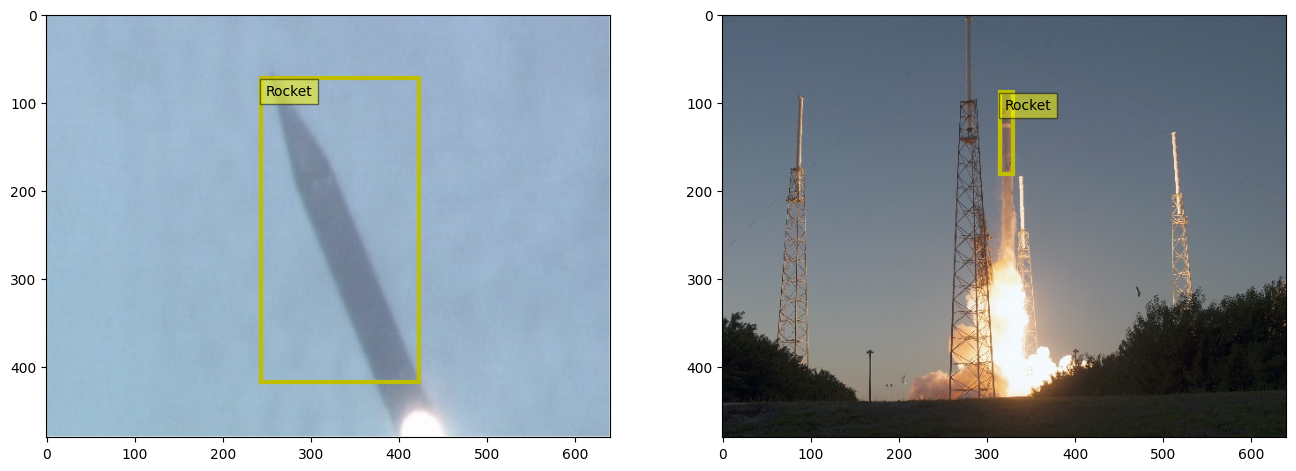

In [10]:
nrows, ncols = (1, NUMBER_OF_SAMPLES)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_vis, fig, axes)
for i, gt_class in enumerate(gt_classes):
    fig, _ = display_bbox(gt_bboxes_vis[i], fig, axes[i], classes=gt_class)

## Convolutional Backbone Network

We will use the first 4 resnet50 residual blocks as our convolutional backbone

In [11]:
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.IMAGENET1K_V2)

In [12]:
req_layers = list(model.children())[:8]
backbone = nn.Sequential(*req_layers)

In [13]:
# unfreeze all the parameters
for param in backbone.named_parameters():
    param[1].requires_grad = True

In [14]:
# run the image through the backbone
out = backbone(img_data_vis)

In [15]:
out_c, out_h, out_w = out.size(dim=1), out.size(dim=2), out.size(dim=3)

In [16]:
out_c, out_h, out_w

(2048, 15, 20)

#### Check how much the image has been down-scaled

In [17]:
width_scale_factor = IMG_WIDTH // out_w
height_scale_factor = IMG_HEIGHT // out_h
height_scale_factor, width_scale_factor

(32, 32)

### Visualize feature maps

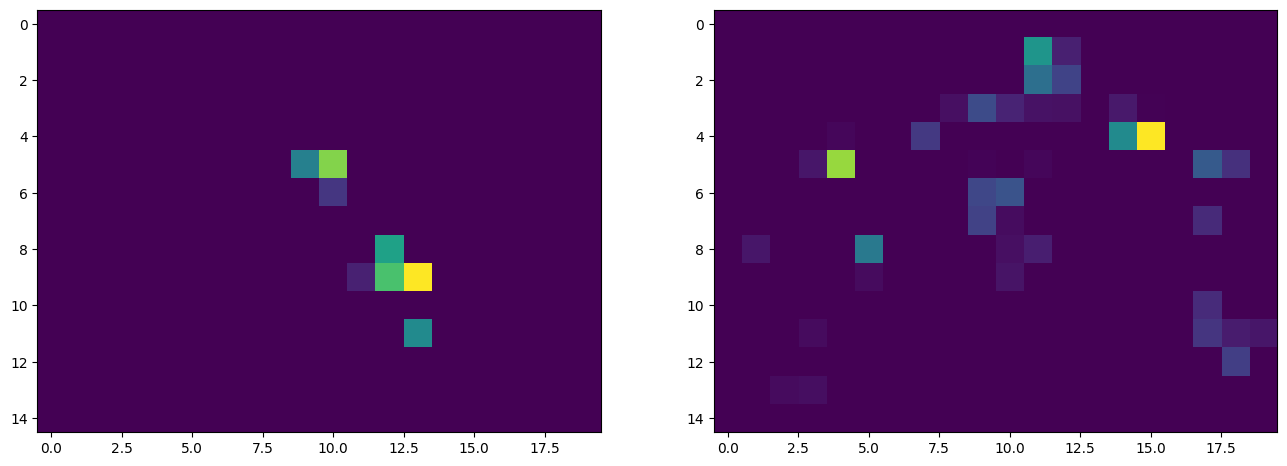

In [18]:
nrows, ncols = (1, NUMBER_OF_SAMPLES)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

filters_data = [filters[0].detach().numpy() for filters in out[:NUMBER_OF_SAMPLES]]

fig, axes = display_img(filters_data, fig, axes)

### Generate and Plot Anchor Points

In [19]:
anc_pts_x, anc_pts_y = gen_anc_centers(out_size=(out_h, out_w))

### Display Grid Mapping

In [20]:
# project anchor centers onto the original image
anc_pts_x_proj = anc_pts_x.clone() * width_scale_factor
anc_pts_y_proj = anc_pts_y.clone() * height_scale_factor

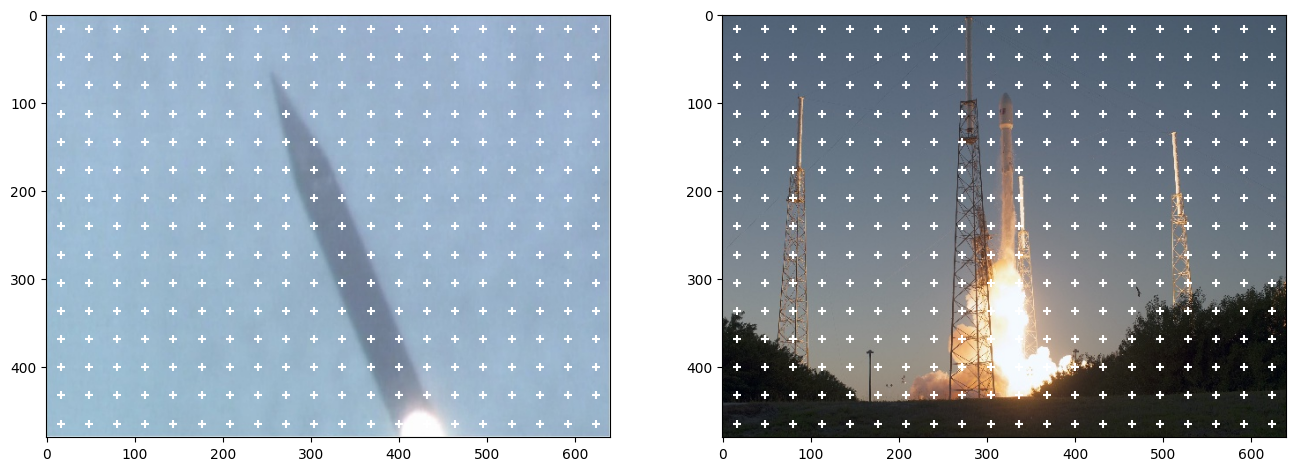

In [21]:
nrows, ncols = (1, NUMBER_OF_SAMPLES)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_vis, fig, axes)
for i, _ in enumerate(img_data_vis):
    fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[i])

### Create Anchor Boxes around Anchor points

Createing template for anchor boxes

In [22]:
ANC_SCALES = [2, 4, 6]
ANC_RATIOS = [0.5, 1, 1.5]

anc_base = gen_anc_base(anc_pts_x, anc_pts_y, ANC_SCALES, ANC_RATIOS, (out_h, out_w))

In [23]:
# since all the images are scaled to the same size
# we can repeat the anchor base for all the images
anc_boxes_all = anc_base.repeat(img_data_vis.size(dim=0), 1, 1, 1, 1)

### Plot anchor boxes on a single anchor point

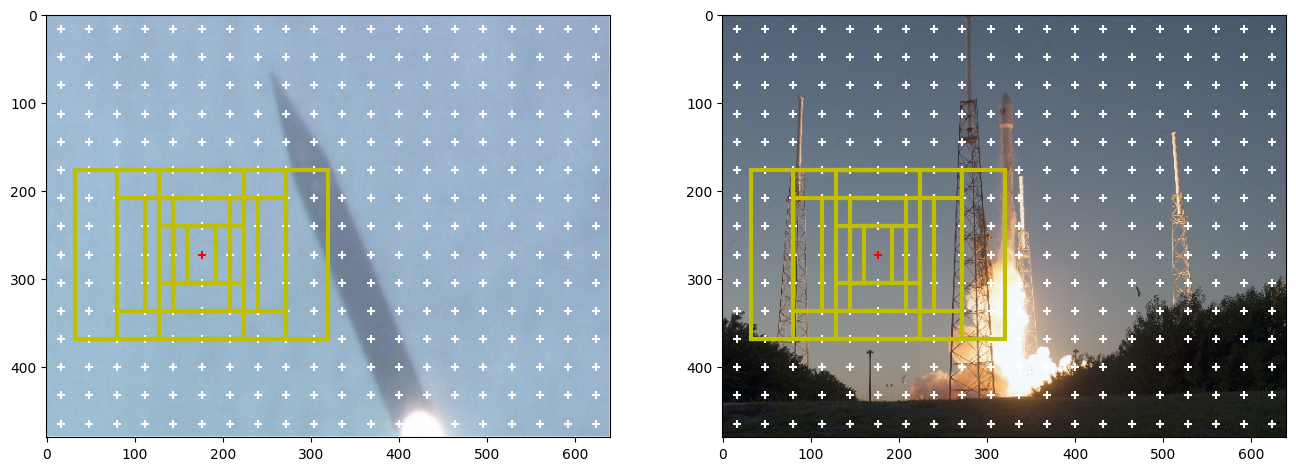

In [24]:
nrows, ncols = (1, NUMBER_OF_SAMPLES)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_vis, fig, axes)

# project anchor boxes to the image
anc_boxes_proj = project_bboxes(anc_boxes_all, width_scale_factor, height_scale_factor, mode='a2p')

# plot anchor boxes around selected anchor points
anch_point_1 = [5, 8]
bboxes_1 = anc_boxes_proj[0][*anch_point_1]


for i, _ in enumerate(gt_classes):
    fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[i], (anc_pts_x_proj[anch_point_1[0]], anc_pts_y_proj[anch_point_1[1]]))
    fig, _ = display_bbox(bboxes_1, fig, axes[i])

### Plot all anchor boxes

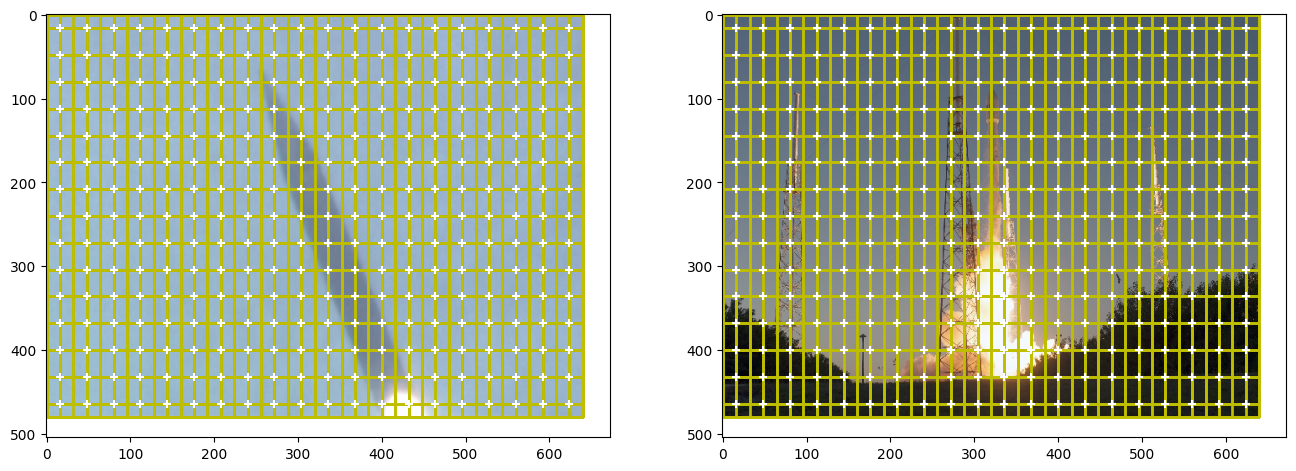

In [25]:
nrows, ncols = (1, NUMBER_OF_SAMPLES)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_vis, fig, axes)

# plot all anchor boxes
for x in range(anc_pts_x_proj.size(dim=0)):
    for y in range(anc_pts_y_proj.size(dim=0)):
        bboxes = anc_boxes_proj[0][x, y]
        for i in range(len(gt_classes_vis)):
            fig, _ = display_bbox(bboxes, fig, axes[i], line_width=1)

# plot feature grid
for i in range(len(gt_classes_vis)):
    fig, _ = display_grid(anc_pts_x_proj, anc_pts_y_proj, fig, axes[i])

### Get Positive and Negative Anchors

In [26]:
pos_thresh = 0.7
neg_thresh = 0.3

# project gt bboxes onto the feature map
gt_bboxes_proj = project_bboxes(gt_bboxes_vis, width_scale_factor, height_scale_factor, mode='p2a')

In [27]:
positive_idxs, negative_idxs, \
GT_positive_classes, _, positive_coords, \
negative_coords, positive_idxs_separate = get_req_anchors(anc_boxes_all, gt_bboxes_proj, gt_classes_vis, pos_thresh, neg_thresh)

#### Visualize positive anchor coordinates

In [28]:
# project anchor coords to the image space
pos_anc_proj = project_bboxes(positive_coords, width_scale_factor, height_scale_factor, mode='a2p')
neg_anc_proj = project_bboxes(negative_coords, width_scale_factor, height_scale_factor, mode='a2p')

In [29]:
anc_indexes = []
for i in range(len(gt_classes)):
    anc_indexes.append(torch.where(positive_idxs_separate == i)[0])

pos_ancs = [pos_anc_proj[anc_idx] for anc_idx in anc_indexes]
neg_ancs = [neg_anc_proj[anc_idx] for anc_idx in anc_indexes]

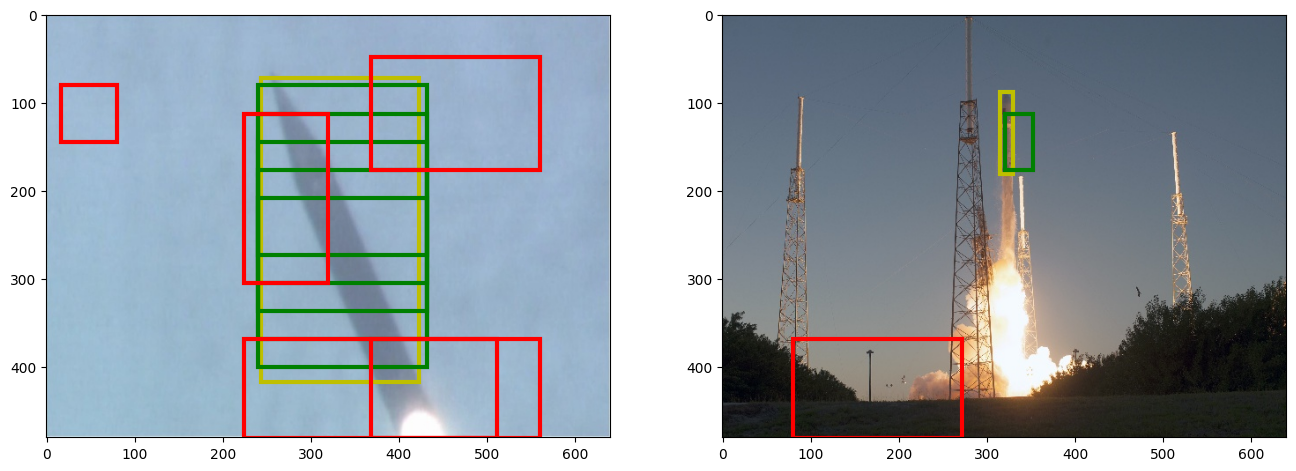

In [30]:
nrows, ncols = (1, NUMBER_OF_SAMPLES)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_data_vis, fig, axes)


for i, _ in enumerate(gt_classes):
    fig, _ = display_bbox(gt_bboxes_vis[i], fig, axes[i])
    fig, _ = display_bbox(pos_ancs[i], fig, axes[i], color='g')
    fig, _ = display_bbox(neg_ancs[i], fig, axes[i], color='r')

### Building the model

In [31]:
img_size = (IMG_HEIGHT, IMG_WIDTH)
out_size = (out_h, out_w)
n_classes = len(name2idx) - 1  # exclude pad idx
roi_size = (2, 2)

detector = TwoStageDetector(img_size, out_size, out_c, n_classes, roi_size, device=DEVICE)

In [32]:
detector.eval()

total_loss = detector(img_batch, gt_bboxes_batch, gt_classes_batch)
proposals_final, conf_scores_final, classes_final = detector.inference(img_batch)

### Training loop

In [33]:
def training_loop(model, learning_rate, train_dataloader, n_epochs):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    model.train()
    loss_list = []

    for i in range(n_epochs):
        print(f"Epoch {i + 1}/{n_epochs}")
        total_loss = 0
        for img_batch, gt_bboxes_batch, gt_classes_batch in tqdm(train_dataloader):
            # forward pass
            loss = model(img_batch, gt_bboxes_batch, gt_classes_batch)

            # backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        loss_list.append(total_loss)

    return loss_list

In [50]:
learning_rate = 1e-3
n_epochs = 20

loss_list = training_loop(detector, learning_rate, dataloader, n_epochs)

Epoch 1/20


100%|██████████| 87/87 [00:16<00:00,  5.33it/s]


Epoch 2/20


100%|██████████| 87/87 [00:16<00:00,  5.39it/s]


Epoch 3/20


100%|██████████| 87/87 [00:16<00:00,  5.37it/s]


Epoch 4/20


100%|██████████| 87/87 [00:16<00:00,  5.30it/s]


Epoch 5/20


100%|██████████| 87/87 [00:16<00:00,  5.29it/s]


Epoch 6/20


100%|██████████| 87/87 [00:16<00:00,  5.38it/s]


Epoch 7/20


100%|██████████| 87/87 [00:16<00:00,  5.31it/s]


Epoch 8/20


100%|██████████| 87/87 [00:16<00:00,  5.35it/s]


Epoch 9/20


100%|██████████| 87/87 [00:16<00:00,  5.38it/s]


Epoch 10/20


100%|██████████| 87/87 [00:16<00:00,  5.30it/s]


Epoch 11/20


100%|██████████| 87/87 [00:16<00:00,  5.34it/s]


Epoch 12/20


100%|██████████| 87/87 [00:16<00:00,  5.40it/s]


Epoch 13/20


100%|██████████| 87/87 [00:16<00:00,  5.43it/s]


Epoch 14/20


100%|██████████| 87/87 [00:16<00:00,  5.42it/s]


Epoch 15/20


100%|██████████| 87/87 [00:16<00:00,  5.36it/s]


Epoch 16/20


100%|██████████| 87/87 [00:16<00:00,  5.40it/s]


Epoch 17/20


100%|██████████| 87/87 [00:15<00:00,  5.45it/s]


Epoch 18/20


100%|██████████| 87/87 [00:15<00:00,  5.44it/s]


Epoch 19/20


100%|██████████| 87/87 [00:15<00:00,  5.45it/s]


Epoch 20/20


100%|██████████| 87/87 [00:16<00:00,  5.42it/s]


In [51]:
loss_list

[395.5065087676048,
 404.96748065948486,
 405.58390986919403,
 398.73878782987595,
 371.3876028060913,
 395.54621934890747,
 404.6699422597885,
 379.906809091568,
 358.52277970314026,
 362.09462183713913,
 374.3421520590782,
 358.4302970767021,
 357.8616822063923,
 340.23872262239456,
 357.8336149454117,
 363.28212708234787,
 349.6397948861122,
 336.1635994911194,
 611.0139718055725,
 483.5279459953308]

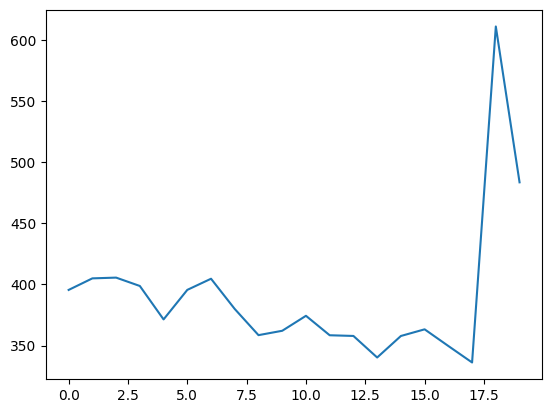

In [52]:
plt.plot(loss_list)

#### save model

In [53]:
torch.save(detector.state_dict(), "model.pt")

### Inference on train data

In [59]:
img_batch, gt_bboxes_batch, gt_classes_batch = next(iter(dataloader))

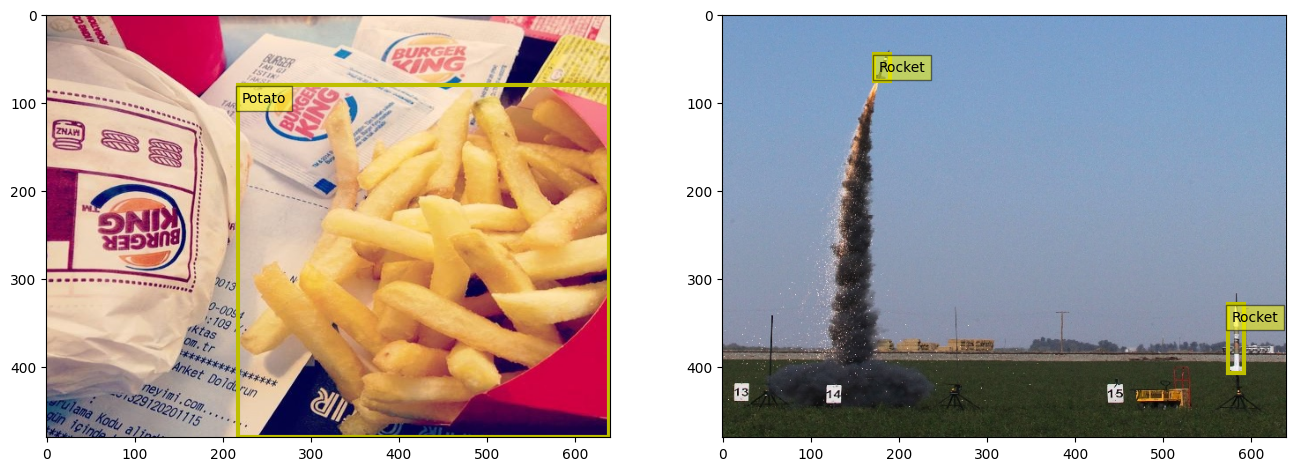

In [67]:
# get class names
gt_classes = []

for i in range(2):
    gt_class = gt_classes_batch[i].long()
    gt_class = [idx2name[idx.item()] for idx in gt_class]
    gt_classes.append(gt_class)
    
nrows, ncols = (1, NUMBER_OF_SAMPLES)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_batch[:2], fig, axes)
for i, gt_class in enumerate(gt_classes):
    fig, _ = display_bbox(gt_bboxes_batch[i], fig, axes[i], classes=gt_class)

In [60]:
detector.eval()
proposals_final, conf_scores_final, classes_final = detector.inference(img_batch, conf_thresh=0.99, nms_thresh=0.05)

In [61]:
# project proposals to the image space
prop_proj_1 = project_bboxes(proposals_final[0], width_scale_factor, height_scale_factor, mode='a2p')
prop_proj_2 = project_bboxes(proposals_final[1], width_scale_factor, height_scale_factor, mode='a2p')

# get classes
classes_pred_1 = [idx2name[cls] for cls in classes_final[0].tolist()]
classes_pred_2 = [idx2name[cls] for cls in classes_final[1].tolist()]

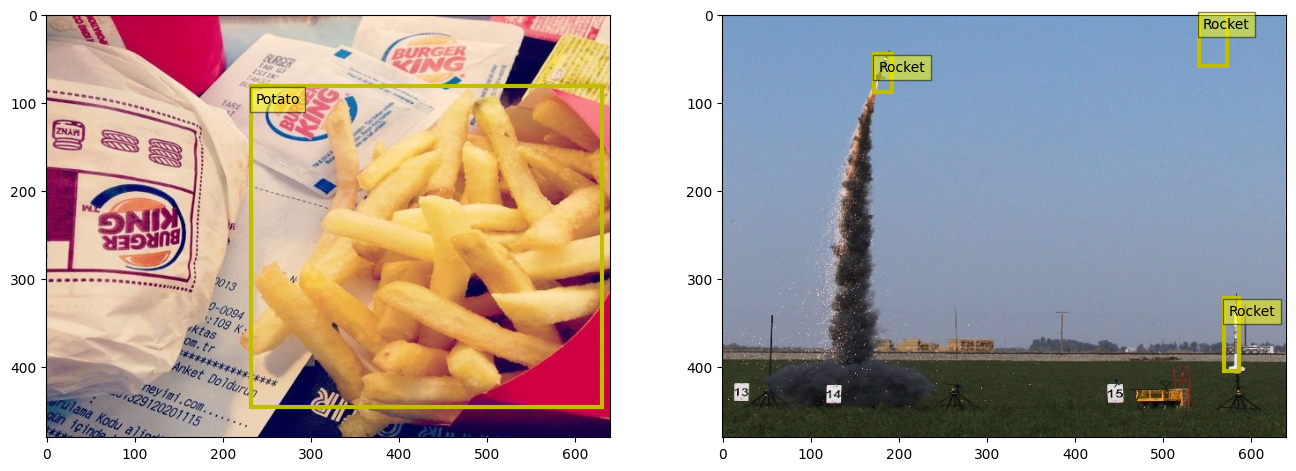

In [62]:
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_batch[:2], fig, axes)
fig, _ = display_bbox(prop_proj_1.cpu(), fig, axes[0], classes=classes_pred_1)
fig, _ = display_bbox(prop_proj_2.cpu(), fig, axes[1], classes=classes_pred_2)

## Test loss

In [121]:
detector.eval()
total_loss_test = 0
with torch.no_grad():
    img_batch, gt_bboxes_batch, gt_classes_batch = next(iter(test_dataloader))
    loss = detector(img_batch, gt_bboxes_batch, gt_classes_batch)   
    total_loss_test += loss.item()

In [118]:
total_loss_test

40.338653564453125

### Inference on test data

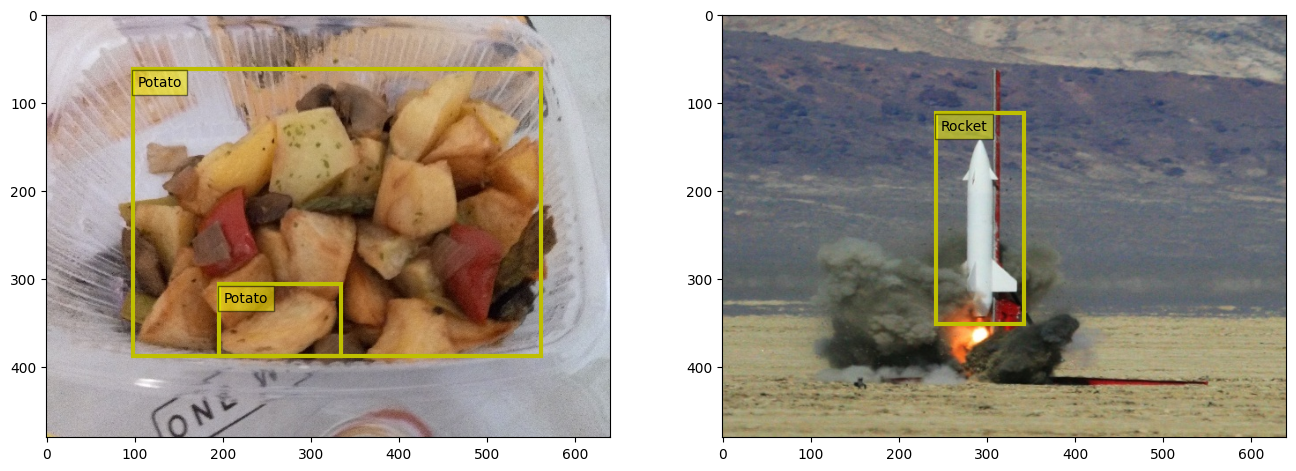

In [110]:
img_batch, gt_bboxes_batch, gt_classes_batch = next(iter(test_dataloader))
# get class names
gt_classes = []

for i in range(2):
    gt_class = gt_classes_batch[i].long()
    gt_class = [idx2name[idx.item()] for idx in gt_class]
    gt_classes.append(gt_class)

nrows, ncols = (1, NUMBER_OF_SAMPLES)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_batch[:2], fig, axes)
for i, gt_class in enumerate(gt_classes):
    fig, _ = display_bbox(gt_bboxes_batch[i], fig, axes[i], classes=gt_class)

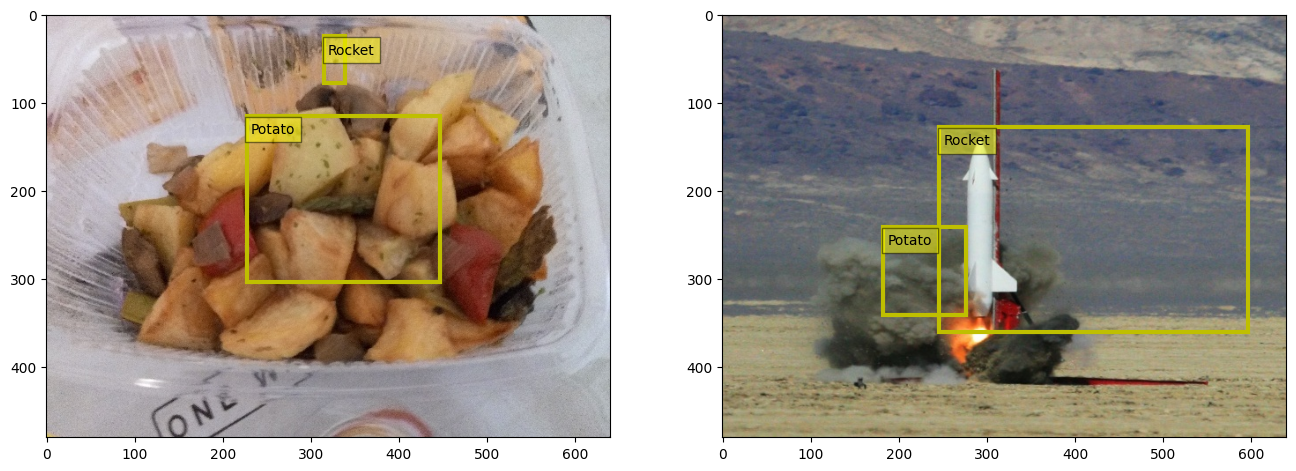

In [111]:
proposals_final, conf_scores_final, classes_final = detector.inference(img_batch, conf_thresh=0.99, nms_thresh=0.05)

# project proposals to the image space
prop_proj_1 = project_bboxes(proposals_final[0], width_scale_factor, height_scale_factor, mode='a2p')
prop_proj_2 = project_bboxes(proposals_final[1], width_scale_factor, height_scale_factor, mode='a2p')

# get classes
classes_pred_1 = [idx2name[cls] for cls in classes_final[0].tolist()]
classes_pred_2 = [idx2name[cls] for cls in classes_final[1].tolist()]
nrows, ncols = (1, 2)
fig, axes = plt.subplots(nrows, ncols, figsize=(16, 8))

fig, axes = display_img(img_batch[:2], fig, axes)
fig, _ = display_bbox(prop_proj_1.cpu(), fig, axes[0], classes=classes_pred_1)
fig, _ = display_bbox(prop_proj_2.cpu(), fig, axes[1], classes=classes_pred_2)